In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from scipy.ndimage import gaussian_filter
import matplotlib.image as image


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [45]:
dir = os.listdir("/data/")
dir

['FAQ_CHESTXRAY.pdf',
 'ARXIV_V5_CHESTXRAY.pdf',
 'images_009',
 'images_011',
 'images_003',
 'images_004',
 'README_CHESTXRAY.pdf',
 'images_012',
 'images_007',
 'images_005',
 'train_val_list.txt',
 'BBox_List_2017.csv',
 'images_001',
 'images_008',
 'LOG_CHESTXRAY.pdf',
 'images_006',
 'test_list.txt',
 'images_002',
 'images_010',
 'Data_Entry_2017.csv']

In [46]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
2074,00000538_004.png,No Finding,4,538,76,F,PA,2992,2991,0.143,0.143,NaN
42997,00011095_000.png,No Finding,0,11095,70,M,PA,2946,2991,0.143,0.143,NaN
53720,00013570_000.png,Effusion|Nodule,0,13570,50,M,PA,2992,2991,0.143,0.143,NaN


In [47]:
# This col seemes to be useless, we might consider dropping it in a later stage
all_xray_df['Unnamed: 11'].isnull().values.any()

True

In [48]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [49]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5529,00030145_001.png,No Finding,1,30145,040Y,F,AP,3056,2544,0.139,0.139
804,00004192_000.png,No Finding,0,4192,049Y,F,PA,2048,2500,0.171,0.171
1315,00006925_004.png,Nodule,4,6925,044Y,F,PA,2500,2048,0.168,0.168


In [50]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


# Global Assets Functions

In [51]:
# Historgram Generation
def GenerateHist(df, xlabel, ylabel, title, grid, figsize):
    
    plt.figure(figsize=figsize)
    ylim, xlim, _ = plt.hist(df)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim.min() * 0.5, xlim.max()*1.2)
    plt.ylim(ylim.min() * 0.5, ylim.max()*1.2)
    plt.grid(grid)

# Plot Generation
def GeneratePlot(figsize, df, kind):
    plt.figure(figsize=figsize)
    df.value_counts().plot(kind=kind)
    
# Subplot Generation
def GenerateSubPlot(figsize, df, kind, x):
    plt.figure(figsize=figsize)
    df.value_counts()[0:x].plot(kind=kind)
    

# Pie chart Generation
def GeneratePieChart(figsize, df, label):
    plt.figure(figsize=figsize)
    df.str.get_dummies().sum().plot.pie(label=label, autopct='%1.1f%%')
    
# Get Image Path
def GetImgPath(row):
    fpath = None
    f = row['Image Index']
    for d in range(12):
        dname = 'images_' + str(d).zfill(3)
        fname = '/data/' + dname + '/images/' + f
        if os.path.isfile(fname):
            fpath = fname
            break
    return fpath

# Exploratory Data Analysis (EDA)


##### 1. Patient Demographic (gender, age, patient position,etc.)

##### Patient Age

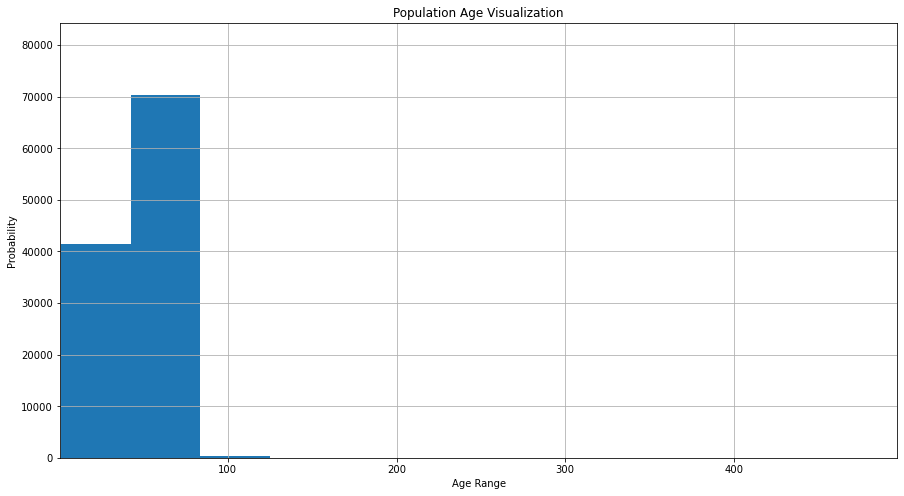

In [52]:
# Visualization
GenerateHist(all_xray_df['Patient Age'], 'Age Range', 'Probability', 'Population Age Visualization', True, (15,8))

In [53]:
# Getting the age range
MAX_AGE = max(all_xray_df['Patient Age'])
MIN_AGE = min(all_xray_df['Patient Age'])

print(f'Max Age: {MAX_AGE}, Min Age: {MIN_AGE}') 

'''It is pretty obvious that the data may not be accuratly labelled, specially for the patient max age. To make our algorithm 
more precise and focused to a specific population range. We would ignore those above 80 and below 20.'''


Max Age: 414, Min Age: 1


'It is pretty obvious that the data may not be accuratly labelled, specially for the patient max age. To make our algorithm \nmore precise and focused to a specific population range. We would ignore those above 80 and below 20.'

In [54]:
# len(all_xray_df[all_xray_df['Patient Age'] > 80]) #897
# len(all_xray_df[all_xray_df['Patient Age'] < 40])

# print(len(all_xray_df.index) - len(all_xray_df[all_xray_df['Patient Age'] < 40]) - len(all_xray_df[all_xray_df['Patient Age'] > 80]))

# print(len(all_xray_df.index) - len(all_xray_df[all_xray_df['Patient Age'] < 20]) - len(all_xray_df[all_xray_df['Patient Age'] > 80]))

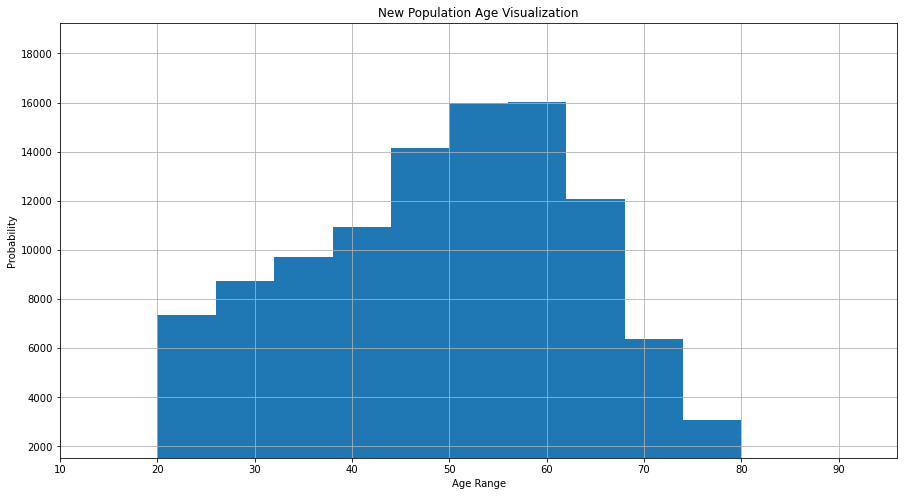

In [55]:
# We would want our algorithm to be trained with group of people with age range between 20 and 80. 

new_xray_df = all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] < 20].index, inplace=False)
new_xray_df = new_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] > 80].index, inplace=False)

GenerateHist(new_xray_df['Patient Age'], 'Age Range', 'Probability', 'New Population Age Visualization', True, (15,8))

# new_xray_df.head(10)
# new_xray_df.shape

In [56]:
new_xray_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN
10,00000003_006.png,Hernia,6,3,79,F,PA,2992,2991,0.143,0.143,NaN
11,00000003_007.png,Hernia,7,3,80,F,PA,2582,2905,0.143,0.143,NaN


In [57]:
# Confirming the age range in the new df. Our focus will be on population age in range between 20 and 80 years old.

MAX_AGE = max(new_xray_df['Patient Age'])
MIN_AGE = min(new_xray_df['Patient Age'])

print(f'Max Age: {MAX_AGE}, Min Age: {MIN_AGE}, DF Shape: {new_xray_df.shape}') 

Max Age: 80, Min Age: 20, DF Shape: (104399, 12)


We will be using the above age range later in this notebook to export a new dataframe for the training and validation process. As for now, other EDA will be on original all_xray_df to further explore the raw dataset.

##### Patient Gender

M    63340
F    48780
Name: Patient Gender, dtype: int64


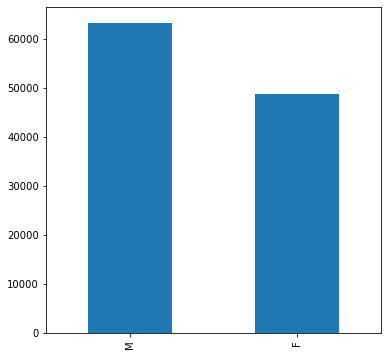

In [58]:
# Visualization
GeneratePlot((6,6), all_xray_df['Patient Gender'], 'bar')

print(all_xray_df['Patient Gender'].value_counts())

##### View Position

PA    67310
AP    44810
Name: View Position, dtype: int64


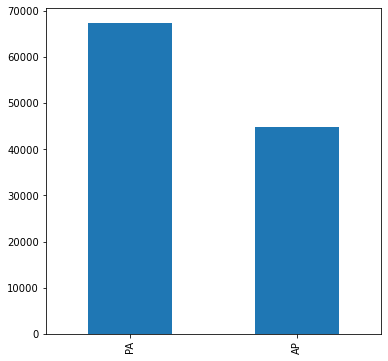

In [59]:
# Visualization
GeneratePlot((6,6), all_xray_df['View Position'], 'bar')

print(all_xray_df['View Position'].value_counts())

There is a significant difference in the scanning position data collected. Let's see for Pneumonia and see how significant it is.

In [60]:
# GenerateHist(all_xray_df[all_xray_df.Pneumonia==1]['View Position'], 'Screening Position', 'Pneumonia Probability', 'Probability of view position to Pneumonia', True, (15,8))

As for the case of Pneumonia across all the dataset, the difference between the two screening positions is not very significant. Thus should be easier while preparing the dataset.

##### Finding Labels

In [61]:
# Splitting raw dataset Labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Also splitting filtered dataset - This is important for later understanding and visualization. 
# Note that it contains only data with age that falls in the range of 20 to 80.
all_labels_new = np.unique(list(chain(*new_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels_new = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels_new), all_labels_new))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        new_xray_df[c_label] = new_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
new_xray_df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,00000003_006.png,Hernia,6,3,79,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,00000003_007.png,Hernia,7,3,80,F,PA,2582,2905,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have 15 Unique types of labels in this dataset

In [63]:
len(all_labels)
# all_labels

15

In [64]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

From the values above, the 'No Finding' is the most common finding. To make an easier comparison, let's visualize all togather below. Also, it is pretty obvious how small is pneumonia findings in this dataset, with complete unbalance in the data collected.

Labels cases #:

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

With Average Number 9435.8.
Minimum images in single class: 227.0.
Max images in single class: 60361.0


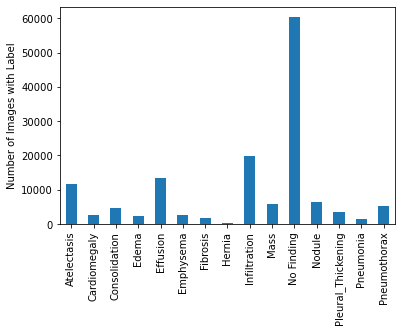

In [65]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

print(f"Labels cases #:\n\n{all_xray_df[all_labels].sum()}\n\nWith Average Number {np.mean(all_xray_df[all_labels].sum())}.\nMinimum images in single class: {min(all_xray_df[all_labels].sum())}.\nMax images in single class: {max(all_xray_df[all_labels].sum())}")

Let's see how common is Pneumonia occurance with other diseases:

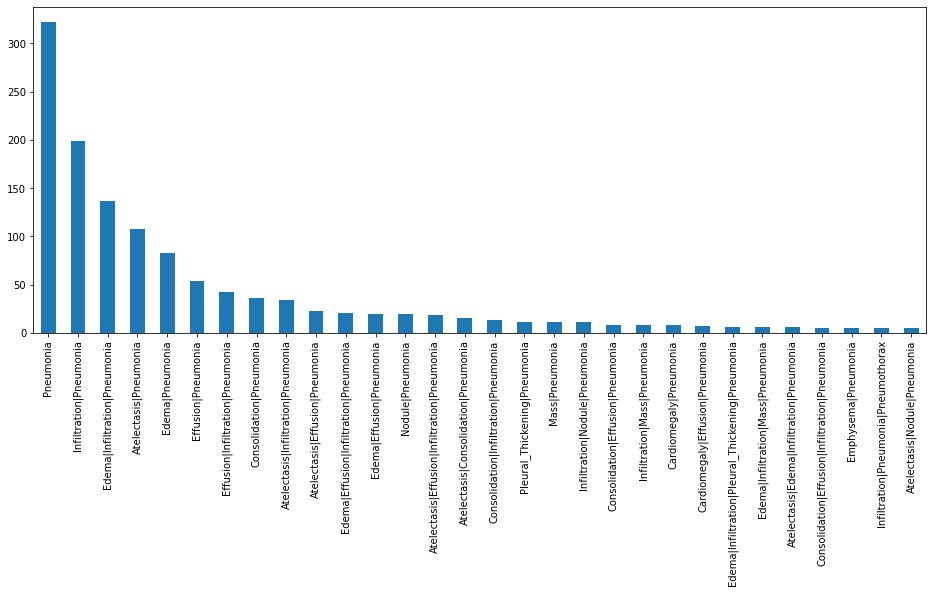

In [66]:
GenerateSubPlot((16,6), all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'], 'bar', 30)

Seems that Pneumonia is mostly common with infiltrates/infitration findings. This can be used to create two nested models as suggested in the rubrics. Where at a high-level, we can classify whether it is Pneumonia or Infiltration, then predict Pneumonia from positive cases returned from the first model. Thus considering only Pneumonia and it's comorbid Infitrations, and may drop others.

Let's see how common Pneumonia in the age range of 20 and 80. Note that the new dataframe of less age span is not used yet in previous analysis as we want to understand the dataset in total.

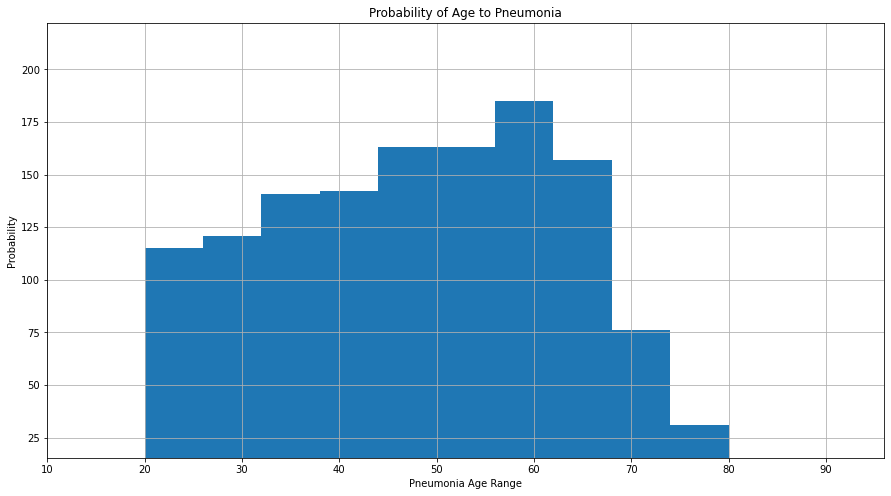

In [67]:
# The new_xray_df carry the same dataset only with age range from 20 to 80, removing those above and below range.
GenerateHist(new_xray_df[new_xray_df.Pneumonia==1]['Patient Age'], 'Pneumonia Age Range', 'Probability', 'Probability of Age to Pneumonia', True, (15,8))

Pneumonia is more common in early age than elderly for this dataset. As for the gender relation below, it is more common in men.

M    838
F    593
Name: Patient Gender, dtype: int64


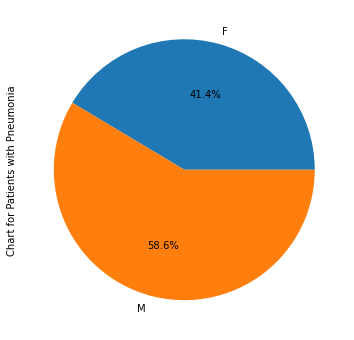

In [68]:
GeneratePieChart((6,6), new_xray_df[new_xray_df.Pneumonia==1]['Patient Gender'], 'Chart for Patients with Pneumonia')
print(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts())

##### Number of disease per patient and then number of disease per patient with Pneumonia found.

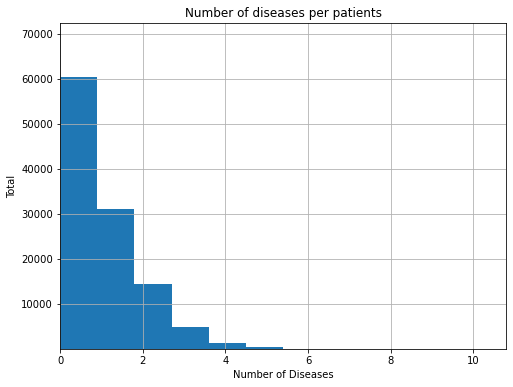

In [69]:
# Number of diseases per patients
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',\
                  'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',\
                  'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
all_xray_df['Disease Total'] = all_xray_df.loc[:, disease_labels].sum(axis=1)

GenerateHist(all_xray_df['Disease Total'], 'Number of Diseases', 'Total', 'Number of diseases per patients', True, (8,6))

<Figure size 720x432 with 0 Axes>

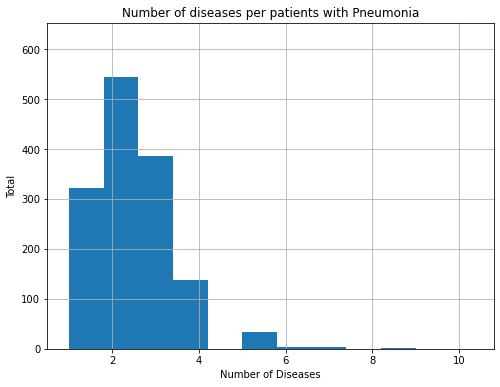

In [70]:
# Number of diseases per patients when Pneumonia is present
plt.figure(figsize=(10,6))
GenerateHist(all_xray_df[all_xray_df.Pneumonia==1]['Disease Total'], 'Number of Diseases', 'Total', 'Number of diseases per patients with Pneumonia', True, (8,6))


In [71]:
# Note that we will have now a 'Disease Total' col.
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Total
95603,00025133_010.png,Consolidation,10,25133,45,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1423,00000372_001.png,Mass,1,372,80,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
73574,00018098_000.png,No Finding,0,18098,44,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Pixel-level assessments

In [72]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
499,00002597_000.png,No Finding,0,2597,054Y,M,PA,2500,2048,0.171,0.171
3260,00016086_002.png,Effusion|Mass,2,16086,060Y,M,PA,2992,2991,0.143,0.143
3055,00015045_018.png,Consolidation,18,15045,029Y,F,AP,2500,2048,0.168,0.168


In [73]:
all_labels_new = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels_new = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels_new), all_labels_new))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [74]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [75]:
sample_df[(sample_df["Finding Labels"] == "Pneumonia") & (sample_df["View Position"] == "PA")].iloc[7]["path_img"]

'/data/images_010/images/00022192_032.png'

In [76]:
pneumonia_images = []

for i in range(6):
    pneumonia_images.append(("Pneumonia", sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["View Position"] == "PA")].iloc[i]["path_img"]))
    

In [77]:
pneumonia_images[3][1]

'/data/images_003/images/00004075_000.png'

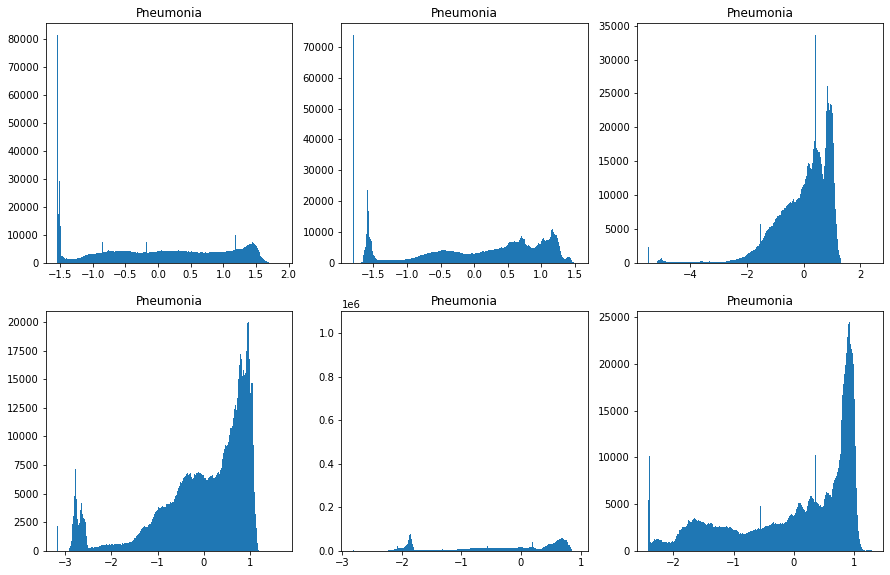

In [78]:
# Displaying 9 samples histograms normalized with Pneumonia condition only
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(pneumonia_images) ):
    plt.subplot(len(pneumonia_images) / columns + 1, columns, i + 1).set_title(pneumonia_images[i][0])
    var = plt.imread(pneumonia_images[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

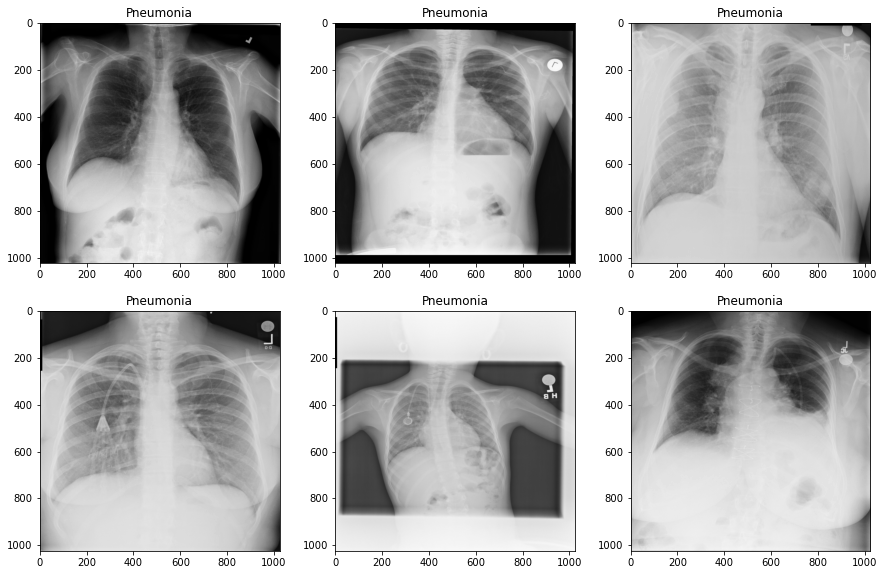

In [79]:
# Displaying 9 samples images with Pneumonia condition only
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(pneumonia_images) ):
    plt.subplot(len(pneumonia_images) / columns + 1, columns, i + 1).set_title(pneumonia_images[i][0])
    img = plt.imread(pneumonia_images[i][1])
    plt.imshow(img, cmap='gray')

Let's have a look on 'No Finding' labeled images to compare the difference.

In [80]:
normal_images = []

for i in range(6):
    normal_images.append(("No Finding", sample_df[(sample_df["No Finding"] == 1) & (sample_df["View Position"] == "PA")].iloc[i]["path_img"]))
    

In [81]:
normal_images

[('No Finding', '/data/images_001/images/00000080_005.png'),
 ('No Finding', '/data/images_001/images/00000083_000.png'),
 ('No Finding', '/data/images_001/images/00000165_008.png'),
 ('No Finding', '/data/images_001/images/00000188_001.png'),
 ('No Finding', '/data/images_001/images/00000194_004.png'),
 ('No Finding', '/data/images_001/images/00000206_000.png')]

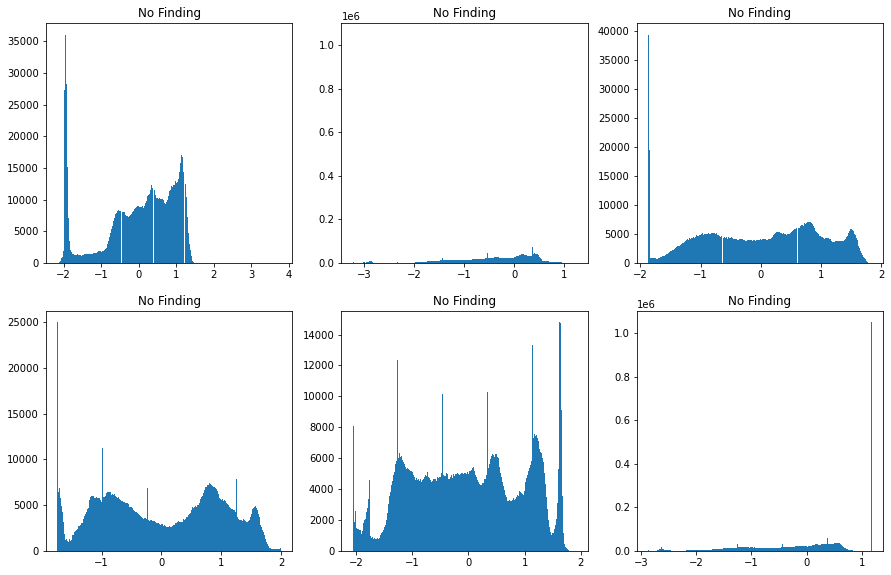

In [82]:
# Displaying 9 samples histograms normalized with Pneumonia condition only
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(normal_images) ):
    plt.subplot(len(normal_images) / columns + 1, columns, i + 1).set_title(normal_images[i][0])
    var = plt.imread(normal_images[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

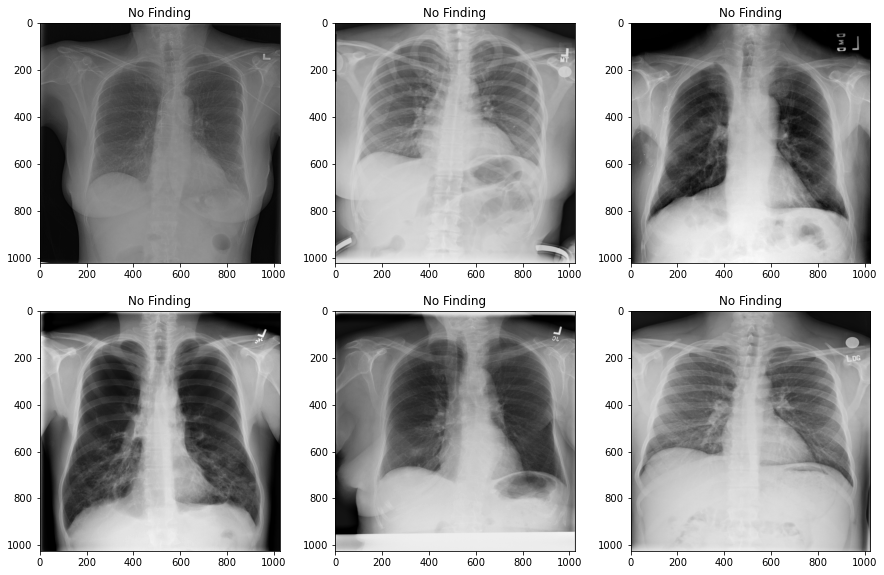

In [83]:
# Displaying 9 samples images with Pneumonia condition only
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(normal_images) ):
    plt.subplot(len(normal_images) / columns + 1, columns, i + 1).set_title(normal_images[i][0])
    img = plt.imread(normal_images[i][1])
    plt.imshow(img, cmap='gray')

### Removing Backgrounds

<Figure size 1080x1080 with 0 Axes>

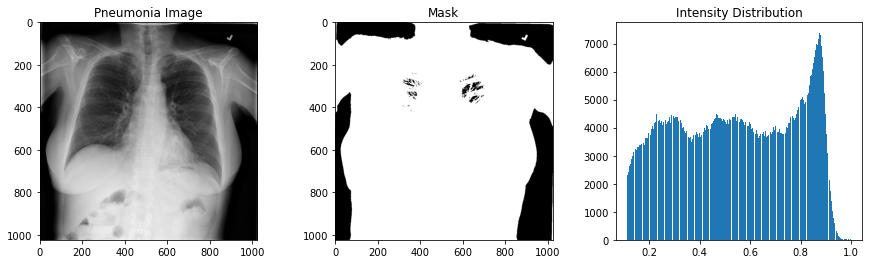

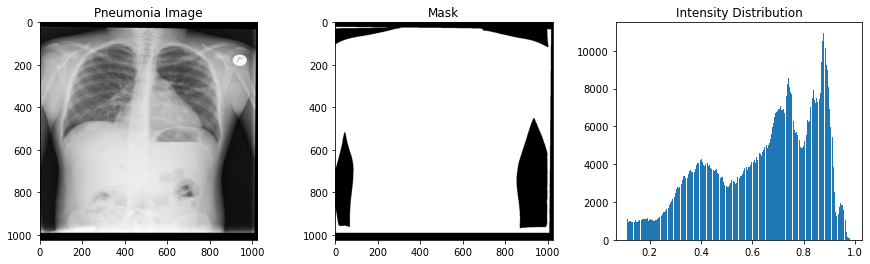

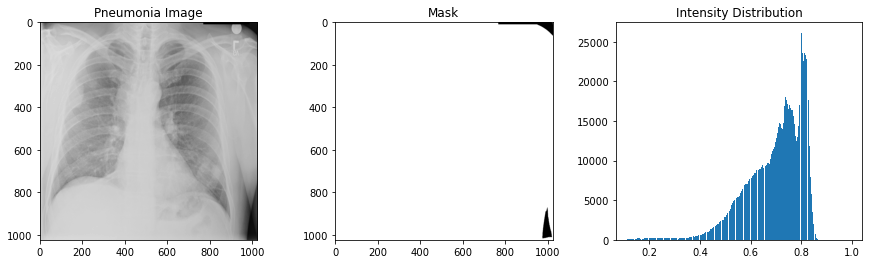

In [84]:
THRESHOLD = 0.11
plt.figure(figsize=(15, 15))
columns = 3


for i in range(len(pneumonia_images[:3]) ):
    
    f = plt.figure()
    f.set_figwidth(15)
    
    img = plt.imread(pneumonia_images[i][1])

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Pneumonia Image')
    plt.imshow(img, cmap='gray')

    mask = img > THRESHOLD

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    plt.hist(img[mask], bins = 256)

    plt.show()

In [85]:
def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1].sample()['path_img'].values
    
    for path in paths:
        data = plt.imread(path)
        mask = data > THRESHOLD
        intensities.extend(img[mask].tolist())
    return intensities


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15


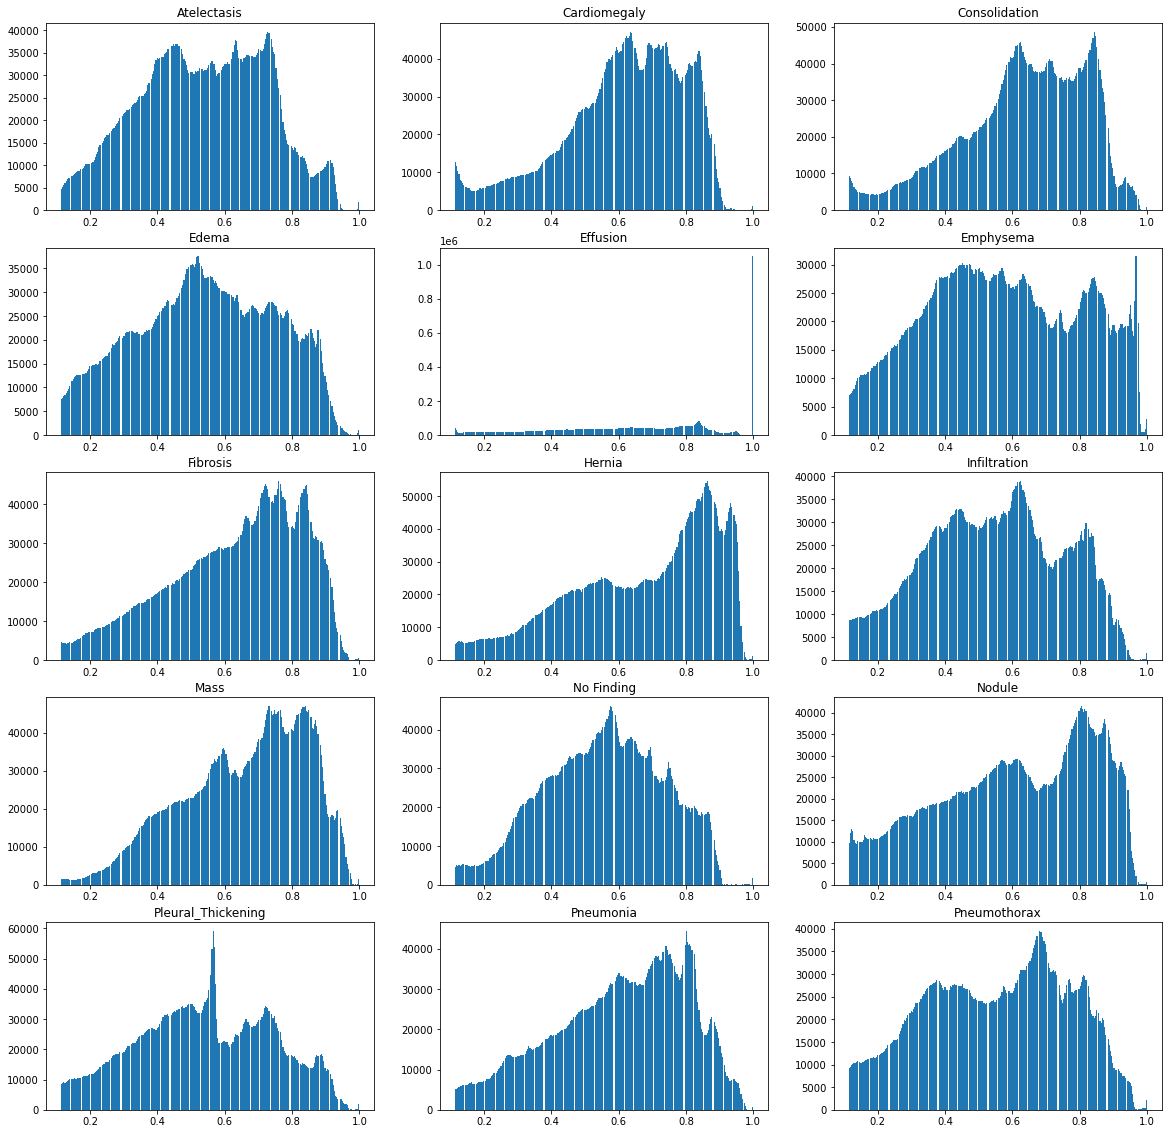

In [86]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
intensity = []

for i,finding in enumerate(all_labels):
    
    intensity = []
    
    paths = sample_df[sample_df[finding]==1].head()['path_img'].values
    
    print(f'Round: {i+1}')
    for path in paths:
        img = plt.imread(path)
        mask = (img > THRESHOLD)
        intensity.extend(img[mask].tolist())
        
    
    s = f.add_subplot(5, len(all_labels)/5, i+1)
    s.set_title(finding)

    plt.hist(intensity, bins = 256)
plt.show()



#### Conclusion

1. Patient age is not given at the best shape as it is very un-real and wide in span. Thus it is important to pre-process and select a smaller range of age, ignoring those unrealistic numbers above 100, preferring  the range of 20 to 80 years old.
2. From the pixel intensities histogram shape, Pneumonia's shape seemed to be quite similar to Fibrosis and Nodule.
3. It should be easy to differentiate between Pneumonia and others like Hemia, Emphysema, Edema, and Atelectasis as the pixel distribution seemed to be very different for most of the values.  